In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
%matplotlib inline

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','JPM','JNJ']

news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [3]:
parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
df['date'] = pd.to_datetime(df.date).dt.date
df

,ticker,date,time,title
0,AAPL,2021-03-21,06:32PM,Dow Jones Futures Fall In Uncertain Market Ral...
1,AAPL,2021-03-21,03:47PM,Saudi Aramco has lost the title of worlds most...
2,AAPL,2021-03-21,12:51PM,How Reddit Makes Money
3,AAPL,2021-03-21,12:30PM,Right to repair: what can you do if your mobil...
4,AAPL,2021-03-21,11:45AM,Battle of Dividend Stocks: Microsoft vs. Apple
...,...,...,...,...
895,JNJ,2021-03-11,09:04AM,Johnson & Johnson Single-Shot Vaccine Cleared ...
896,JNJ,2021-03-11,08:52AM,Stimulus Package & Vaccine Rollout to Aid Reco...
897,JNJ,2021-03-11,07:54AM,EU Governments Are Bracing for More Covid Vacc...
898,JNJ,2021-03-11,07:39AM,5 Top Blue Chip Stocks to Buy as Dow Breezes P...


In [4]:
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df['compound']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0     -0.2960
1      0.2247
2      0.0000
3      0.0000
4     -0.3818
        ...  
895    0.1027
896    0.0000
897    0.0000
898    0.2023
899    0.0000
Name: compound, Length: 900, dtype: float64

In [5]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
#mean_df = df.groupby(['ticker', 'date']).mean().unstack().dropna(axis='columns', thresh=7)
mean_df

compound                        ...                                 
date   2021-02-26 2021-02-27 2021-02-28  ... 2021-03-19 2021-03-20 2021-03-21
ticker                                   ...                                 
AAPL          NaN        NaN        NaN  ...  -0.039889   0.051392  -0.124887
AMZN          NaN        NaN        NaN  ...   0.211442  -0.059078   0.134650
FB            NaN        NaN        NaN  ...   0.013245   0.471733   0.058480
GOOG          NaN        NaN        NaN  ...  -0.098389   0.359100  -0.244182
GOOGL         NaN        NaN        NaN  ...  -0.098389   0.359100  -0.210010
JNJ           NaN        NaN        NaN  ...   0.152767        NaN   0.237700
JPM       0.00645     0.4944        0.0  ...        NaN   0.220200        NaN
MSFT          NaN        NaN        NaN  ...   0.030650   0.000000  -0.190900
TSLA          NaN        NaN        NaN  ...  -0.038910   0.127038   0.162975

[9 rows x 23 columns]

<Figure size 720x576 with 0 Axes>

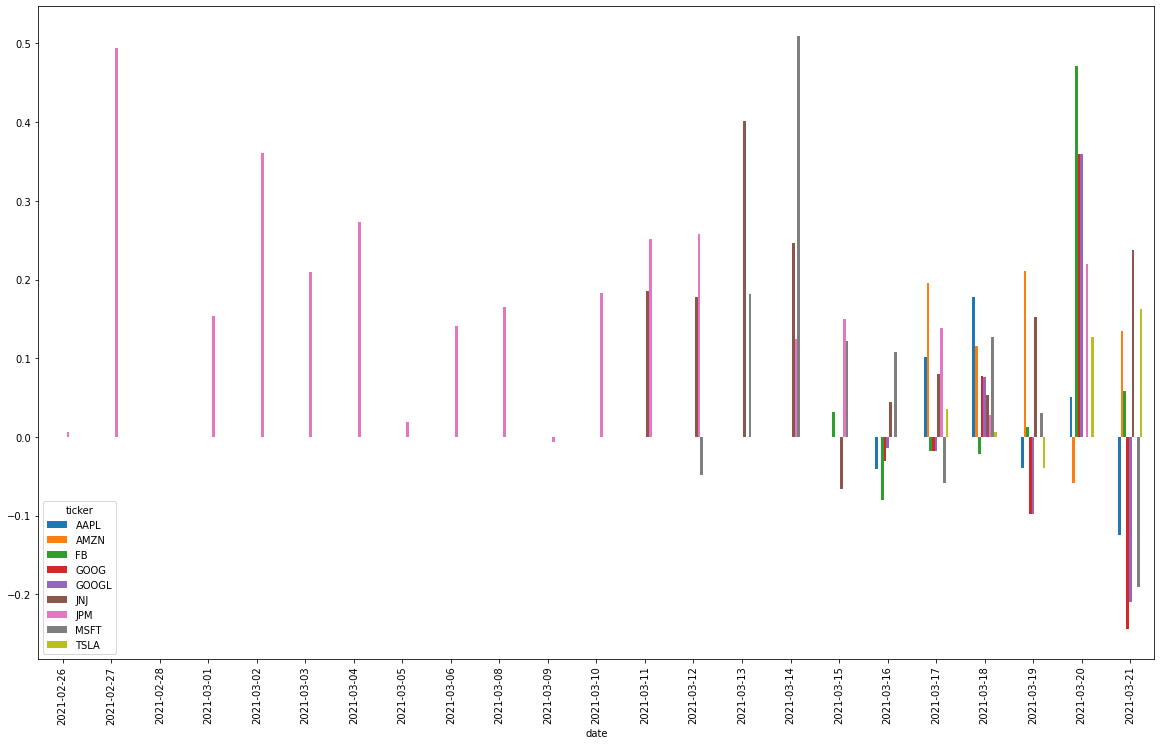

In [6]:
mean_df = mean_df.xs('compound', axis="columns").transpose()
mean_df.plot(kind='bar', figsize=(20, 12))
plt.show()

In [7]:
df['comp_class'] = [1 if x > 0 else 0 for x in df['compound']] 
df['comp_class']

0      0
1      1
2      0
3      0
4      0
      ..
895    1
896    0
897    0
898    1
899    0
Name: comp_class, Length: 900, dtype: int64

In [8]:
# Create the features set (X) and the target vector (y)
X = df['title'].values
y = df['comp_class'].values

In [9]:
# Create the train, test, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [10]:
# Import the libraries for sentiment scoring using Vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [11]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [13]:
# Define two lists to store vader sentiment scoring
y_vader_pred = []
y_vader_prob = []

In [14]:
# Score sentiment of test set using Vader
for comment in X_test:
    y_vader_prob.append(analyzer.polarity_scores(comment)["pos"])
    sentiment_score = analyzer.polarity_scores(comment)["compound"]
    if sentiment_score >= 0.1:
        y_vader_pred.append(1)
    else:
        y_vader_pred.append(0)

In [15]:
# Option 1: Normalizing data using MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.array(y_vader_prob).reshape(-1,1))
y_vader_prob_norm = scaler.transform(np.array(y_vader_prob).reshape(-1,1))
y_vader_prob_norm[:200]

array([[0.70398482],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.69829222],
       [0.39089184],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.43833017],
       [0.33206831],
       [0.        ],
       [0.        ],
       [0.18595825],
       [0.        ],
       [0.        ],
       [0.61480076],
       [0.        ],
       [0.        ],
       [0.35863378],
       [0.41745731],
       [0.29981025],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.31119545],
       [0.42694497],
       [0.77419355],
       [0.        ],
       [0.64895636],
       [0.41745731],
       [0.29032258],
       [0.20303605],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.4971537 ],
       [0.38519924],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.19165085],
       [0.48387097],
       [0.683

In [16]:
# Option 2: Using a comprehension list
normalized = [(x - min(y_vader_prob)) / (max(y_vader_prob) - min(y_vader_prob))
              for x in y_vader_prob]
normalized[:5]

[0.7039848197343453, 0.0, 0.0, 0.0, 0.698292220113852]

In [17]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [18]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [19]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:5]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'to', token: 1
word: 'in', token: 2
word: 'the', token: 3
word: 'for', token: 4
word: 'a', token: 5


In [20]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

In [21]:
# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})

**Text comment**
{'Dow Jones Futures Fall In Uncertain Market Rally; ARK Sets $3,000 Tesla Price Target'}


In [22]:
print("**Numerical sequence representation**")
print(X_seq[0])

**Numerical sequence representation**
[19, 28, 47, 285, 2, 441, 18, 103, 286, 287, 26, 65, 16, 181, 131]


In [23]:
# Import the pad_sequences method from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# Set the pad size
max_words = 140

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq, maxlen=max_words, padding="post")

In [25]:
# Creating training, validation, and testing sets using the encoded data
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, y)

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [26]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [27]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
embedding_size = 64

In [28]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

In [29]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [30]:
# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 64)           148224    
_________________________________________________________________
lstm (LSTM)                  (None, 280)               386400    
_________________________________________________________________
dense (Dense)                (None, 1)                 281       
Total params: 534,905
Trainable params: 534,905
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Training the model
batch_size = 1000
epochs = 10
model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 0.6923 - accuracy: 0.6186 - tp: 0.0000e+00 - tn: 313.0000 - fp: 0.0000e+00 - fn: 193.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.6789 - val_accuracy: 0.6568 - val_tp: 0.0000e+00 - val_tn: 111.0000 - val_fp: 0.0000e+00 - val_fn: 58.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.6827 - accuracy: 0.6186 - tp: 0.0000e+00 - tn: 313.0000 - fp: 0.0000e+00 - fn: 193.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.6656 - val_accuracy: 0.6568 - val_tp: 0.0000e+00 - val_tn: 111.0000 - val_fp: 0.0000e+00 - val_fn: 58.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.6736 - accuracy: 0.6186 - tp: 0.0000e+00 - tn: 313.0000 - fp: 0.0000e+00 - fn: 193.0000 - precision: 0.0000

In [32]:
# Predict classes using the testing data
y_rnn_pred = model.predict_classes(X_test_rnn, batch_size=1000)

In [33]:
# Accuracy
from sklearn.metrics import accuracy_score



print("Vader Accuracy: %.2f" % (accuracy_score(y_test, y_vader_pred)))
print("RNN LSTM Accuracy %.2f" % (accuracy_score(y_test_rnn, y_rnn_pred)))

Vader Accuracy: 0.99
RNN LSTM Accuracy 0.60


In [34]:
# Import the confusion_matrix method from sklearn
from sklearn.metrics import confusion_matrix

In [35]:
# Confusion matrtix metrics from Vader
tn_vader, fp_vader, fn_vader, tp_vader = confusion_matrix(y_test, y_vader_pred).ravel()

# Dataframe to display confusion matrix from Vader
cm_vader_df = pd.DataFrame(
    {
        "Positive(1)": [f"TP={tp_vader}", f"FP={fp_vader}"],
        "Negative(0)": [f"FN={fn_vader}", f"TN={tn_vader}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_vader_df.index.name = "Actual"
cm_vader_df.columns.name = "Predicted"
print("Confusion Matrix from Vader")
display(cm_vader_df)

Confusion Matrix from Vader


Predicted,Positive(1),Negative(0)
Actual,,
Positive(1),TP=78,FN=3
Negative(0),FP=0,TN=144


In [36]:
# Confusion matrtix metrics from the RNN LSTM model
tn_rnn, fp_rnn, fn_rnn, tp_rnn = confusion_matrix(y_test_rnn, y_rnn_pred).ravel()

# Dataframe to display confusion matrix from the RNN LSTM model
cm_rnn_df = pd.DataFrame(
    {
        "Positive(1)": [f"TP={tp_rnn}", f"FP={fp_rnn}"],
        "Negative(0)": [f"FN={fn_rnn}", f"TN={tn_rnn}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_rnn_df.index.name = "Actual"
cm_rnn_df.columns.name = "Predicted"
print("Confusion Matrix from the RNN LSTM Model")
display(cm_rnn_df)

Confusion Matrix from the RNN LSTM Model


Predicted,Positive(1),Negative(0)
Actual,,
Positive(1),TP=0,FN=90
Negative(0),FP=0,TN=135


In [37]:
# Import the classification_report method from sklearn
from sklearn.metrics import classification_report

In [38]:
# Display classification report for Vader
print("Classification Report for Vader")
print(classification_report(y_vader_pred, y_test))

Classification Report for Vader
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       147
           1       0.96      1.00      0.98        78

    accuracy                           0.99       225
   macro avg       0.98      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



In [39]:
# Display classification report for the RNN LSTM Model
print("Classification Report for the RNN LSTM Model")
print(classification_report(y_rnn_pred, y_test_rnn))

Classification Report for the RNN LSTM Model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       225
           1       0.00      0.00      0.00         0

    accuracy                           0.60       225
   macro avg       0.50      0.30      0.37       225
weighted avg       1.00      0.60      0.75       225



In [40]:
# Import the roc_curve and auc metrics from sklearn
from sklearn.metrics import roc_curve, auc

In [41]:
# Data for ROC Curve - VADER
fpr_test_vader, tpr_test_vader, thresholds_test_vader = roc_curve(y_test, y_vader_prob_norm)

In [42]:
# AUC for VADER
auc_test_vader = auc(fpr_test_vader, tpr_test_vader)
auc_test_vader = round(auc_test_vader, 4)

In [43]:
# Dataframe to plot ROC Curve for VADER
roc_df_test_vader = pd.DataFrame({"FPR Test": fpr_test_vader, "TPR Test": tpr_test_vader,})

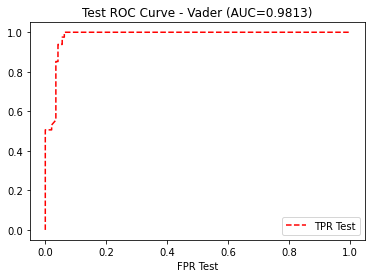

In [44]:
roc_df_test_vader.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve - Vader (AUC={auc_test_vader})",
)

In [45]:
# Making predictions to feed the roc_curve module
test_predictions_rnn = model.predict(X_test_rnn, batch_size=1000)

In [46]:
# Data for ROC Curve - RNN LSTM Model
fpr_test_rnn, tpr_test_rnn, thresholds_test_rnn = roc_curve(y_test_rnn, test_predictions_rnn)

In [47]:
# AUC for the RNN LSTM Model
auc_test_rnn = auc(fpr_test_rnn, tpr_test_rnn)
auc_test_rnn = round(auc_test_rnn, 4)

In [48]:
# Dataframe to plot ROC Curve for the RNN LSTM model
roc_df_test_rnn = pd.DataFrame({"FPR Test": fpr_test_rnn, "TPR Test": tpr_test_rnn,})

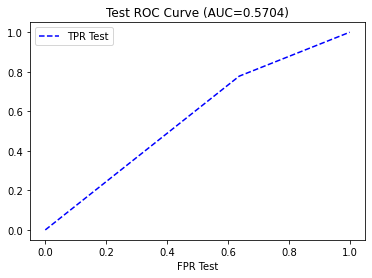

In [49]:
roc_df_test_rnn.plot(
    x="FPR Test",
    y="TPR Test",
    color="blue",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test_rnn})",
)